In [ ]:
import os
import random
import math
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import cv2
import pydicom

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms.functional as F
from torchvision import datasets, models, transforms

from IPython.display import clear_output
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

## Save .dcm into .png

Reading .png is faster than .dcm ⇒ training is faster with .png

In [ ]:
def get_transform(target_size):
    transform = []
    transform.append(transforms.ToTensor())
    transform.append(transforms.Resize(target_size))
    return transforms.Compose(transform)

img_name = f"stage_2_train_images/0a0f91dc-6015-4342-b809-d19610854a21.dcm"

image = pydicom.read_file(img_name).pixel_array
image = image[..., np.newaxis]

preprocess = get_transform((256, 256))
image = preprocess(image)
print(image.shape, type(image), torch.max(image))
image

In [ ]:
data = pd.read_csv('target.csv')
data = data.drop_duplicates(subset=['patientId'])

for i in tqdm(data['patientId']):
    img_name = f"stage_2_train_images/{i}.dcm"

    image = pydicom.read_file(img_name).pixel_array
    image = image[..., np.newaxis]

    preprocess = get_transform((256, 256))
    image = preprocess(image)

    torchvision.utils.save_image(image, f'train_png/{i}.png')

## Plot example images

In [ ]:
image_no = torchvision.io.read_image(f'train_png/0004cfab-14fd-4e49-80ba-63a80b6bddd6.png').permute(1,2,0).numpy()
image_yes = torchvision.io.read_image(f'train_png/00436515-870c-4b36-a041-de91049b9ab4.png').permute(1,2,0).numpy()

In [ ]:
image_yes = cv2.rectangle(image_yes,(264 // 4,152 // 4),((264 + 213) // 4, (152+359) // 4),(0,255,0),3)

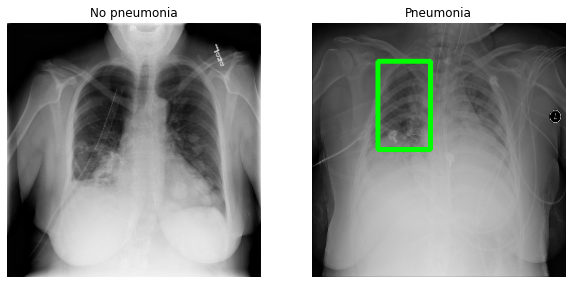

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_no)
axes[0].set_title('No pneumonia')
axes[0].axis('off')
axes[1].imshow(image_yes)
axes[1].set_title('Pneumonia')
axes[1].axis('off')
plt.show()

## Retrieved images for multilabel pipeline

In [ ]:
data = pd.read_csv('target.csv')
data = data.drop_duplicates(subset=['patientId'])
images_train, images_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Target'])

In [ ]:
with open('arrays_multilabel.npy', 'rb') as f:
    test_array = np.load(f)
    test_y_a = np.load(f)
    test_y_e = np.load(f)
    test_y_i = np.load(f)
    test_y_t = np.load(f)
    train_array = np.load(f)
    train_y_a = np.load(f)
    train_y_e = np.load(f)
    train_y_i = np.load(f)
    train_y_t = np.load(f)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_array, train_y_t)
y_pred = neigh.predict(test_array)
accuracy_score(test_y_t, y_pred)

0.8004496908375491

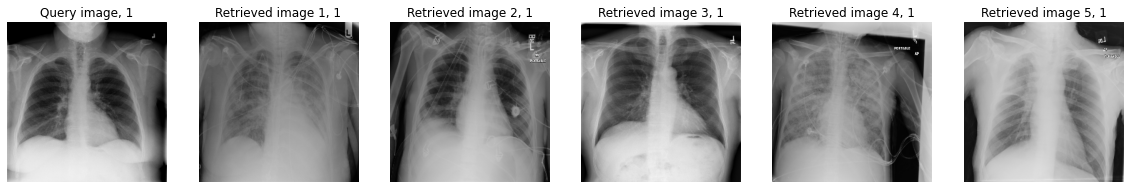

In [ ]:
m = -1
_, t = neigh.kneighbors([test_array[m]])

fig, axes = plt.subplots(1, 6, figsize=(20, 6))
image = torchvision.io.read_image(f"train_png/{images_test['patientId'].iloc[m]}.png").permute(1,2,0).numpy()
axes[0].imshow(image)
axes[0].set_title(f'Query image, {int(test_y_t[m])}')
axes[0].axis('off')

for i, name in enumerate(t[0]):
    image = torchvision.io.read_image(f"train_png/{images_train['patientId'].iloc[name]}.png").permute(1,2,0).numpy()
    axes[i + 1].imshow(image)
    axes[i + 1].set_title(f'Retrieved image {i + 1}, {int(train_y_t[name])}')
    axes[i + 1].axis('off')
plt.show()

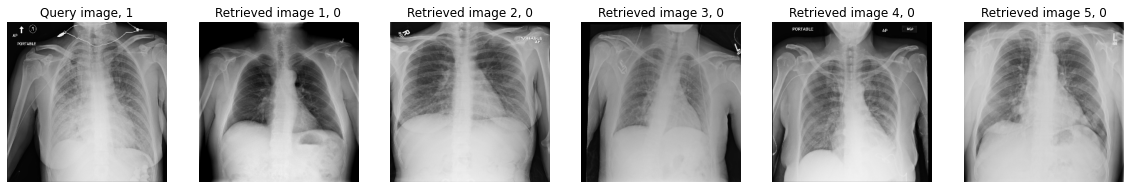

In [ ]:
m = 2
_, t = neigh.kneighbors([test_array[m]])

fig, axes = plt.subplots(1, 6, figsize=(20, 6))
image = torchvision.io.read_image(f"train_png/{images_test['patientId'].iloc[m]}.png").permute(1,2,0).numpy()
axes[0].imshow(image)
axes[0].set_title(f"Query image, {int(images_test['Target'].iloc[m])}")
axes[0].axis('off')

for i, name in enumerate(t[0]):
    image = torchvision.io.read_image(f"train_png/{images_train['patientId'].iloc[name]}.png").permute(1,2,0).numpy()
    axes[i + 1].imshow(image)
    axes[i + 1].set_title(f"Retrieved image {i + 1}, {int(images_train['Target'].iloc[name])}")
    axes[i + 1].axis('off')
plt.show()

## KNN plot for binary classification

In [ ]:
with open('array_binary.npy', 'rb') as f:
    test_array = np.load(f)
    test_y = np.load(f)
    train_array = np.load(f)
    train_y = np.load(f)

In [ ]:
x = list(range(1, 11))
y = []
for k in tqdm(x):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_array, train_y)
    y_pred = neigh.predict(test_array)
    y.append(accuracy_score(test_y, y_pred))

100%|██████████| 10/10 [00:59<00:00,  5.90s/it]


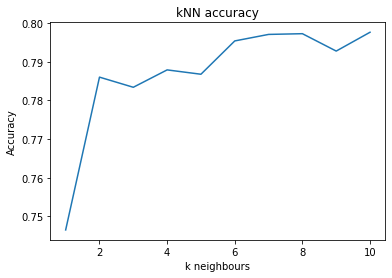

In [ ]:
plt.plot(x, y)
plt.title('kNN accuracy')
plt.ylabel('Accuracy')
plt.xlabel('k neighbours')
plt.show()

## Target EDA

In [ ]:
data = pd.read_csv('../target.csv')
data = data.drop_duplicates(subset=['patientId'])
cols_list = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
             'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] + ['Target']

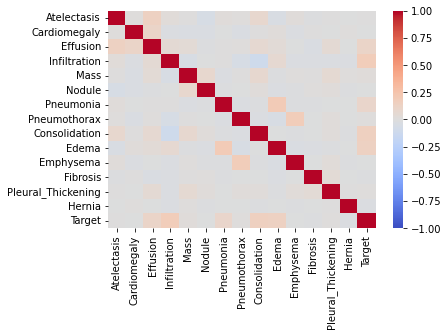

In [ ]:
import seaborn as sns
uniform_data = data[cols_list].corr()
sns.heatmap(uniform_data, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

In [ ]:
for col in cols_list:
    print(f'{col :<20} {sum(data[col]) / data.shape[0] * 100 :.2f}%')

Atelectasis          15.41%
Cardiomegaly         3.31%
Effusion             17.85%
Infiltration         41.29%
Mass                 7.22%
Nodule               7.90%
Pneumonia            3.02%
Pneumothorax         6.18%
Consolidation        9.61%
Edema                3.55%
Emphysema            2.86%
Fibrosis             1.97%
Pleural_Thickening   4.15%
Hernia               0.25%
